<a href="https://colab.research.google.com/github/shyamgupta196/LearningPyTorch/blob/main/heart%20rate%20prediction%20using%20face%20expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [ ]:
# install timm for xception model
!pip install timm transformers pytorch-lightning 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 6.5 MB/s 
     |████████████████████████████████| 5.8 MB 60.7 MB/s 
     |████████████████████████████████| 800 kB 76.8 MB/s 
     |████████████████████████████████| 182 kB 78.7 MB/s 
     |████████████████████████████████| 7.6 MB 70.5 MB/s 
     |████████████████████████████████| 512 kB 71.9 MB/s 
     |████████████████████████████████| 125 kB 72.9 MB/s 


In [ ]:
import os
import zipfile
import importlib
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision.transforms import transforms
from random import sample


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import transformers
import timm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
print(torch. __version__)


1.13.0+cu116


In [ ]:
print(torchvision. __version__)

0.14.0+cu116


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive')
from modules import process_data, network_f, network_architectures
importlib.reload(network_architectures)

<module 'modules.network_architectures' from '/content/drive/MyDrive/modules/network_architectures.py'>

## data

### get data

In [ ]:
data_path = '/content/drive/MyDrive/Thesis_Reading'

subjects = glob(data_path + '/*')

In [ ]:
# code to extract zips, ignore if already extracted

# for subj in tqdm(subjects):
#   zipf_path = glob(subj + '/*.zip')[0]
#   dest_path = zipf_path[:-4]

#   with zipfile.ZipFile(zipf_path, 'r') as zip_ref:
#     zip_ref.extractall(dest_path)

In [ ]:
subj_data = {}


for subj in tqdm(subjects):
  fls = glob(subj + '/*')
  fls = os.listdir(subj)
  subj_id = 'subj_' + subj.split('/')[-1]

  for fl in fls:
    fl_path = f'{subj}/{fl}'
    if fl.endswith('.csv'):
      if fl.startswith('Data'):
        sensor_path = fl_path
      else:
        survey_path = fl_path
    elif os.path.isdir(fl_path):
      hr_path = fl_path

  sensor_data = pd.read_csv(sensor_path)
  channels = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']
  watch_data = np.stack([sensor_data[ch].values for ch in channels])
  watch_data = {'epoch': sensor_data['epoch'].values, 'values': watch_data}

  survey_data = pd.read_csv(survey_path)
  survey_data = {k:v for k,v in survey_data.items() if 'emo' not in k}
  
  hr_data = pd.read_csv(f'{hr_path}/HR.csv')
  hr_data = process_data.process_hr(hr_data, watch_data['epoch'][-1])

  subj_data[subj_id] = {'watch_data':watch_data, 'survey_data':survey_data, 'hr_data':hr_data}

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
watch_data

{'epoch': array([1661266382611, 1661266382615, 1661266382620, ..., 1661268390455,
        1661268390460, 1661268390465]),
 'values': array([[-4.19067383e-01, -4.21508784e-01, -4.23950186e-01, ...,
         -7.81372080e-01, -7.83721928e-01, -7.86071777e-01],
        [-3.73657227e-01, -3.74114989e-01, -3.74572752e-01, ...,
         -8.54492188e-04, -8.54492188e-04, -8.54492188e-04],
        [ 8.28186035e-01,  8.30688472e-01,  8.33190908e-01, ...,
          6.52099616e-01,  6.53778079e-01,  6.55456543e-01],
        [ 8.53658557e-01,  8.53658557e-01,  8.53658557e-01, ...,
          1.34146333e+00,  1.31097555e+00,  1.28048778e+00],
        [ 7.31707335e-01,  6.09756351e-01,  4.87805367e-01, ...,
          2.25609744e+00,  2.22560972e+00,  2.19512200e+00],
        [ 3.04878056e-01,  3.65853548e-01,  4.26829040e-01, ...,
          7.31707335e-01,  7.31707335e-01,  7.31707335e-01]])}

In [ ]:
print( subj_data['subj_1']['hr_data'].keys() )
print( len(subj_data['subj_1']['hr_data']['epoch']) )

# check time difference
end_time = subj_data['subj_1']['hr_data']['epoch'][-1]
start_time = subj_data['subj_1']['hr_data']['epoch'][0]
time_diff = end_time - start_time
time_diff /= 1000 # ms to s
time_diff /= 60 # s to min
print(time_diff)


# video is sampled every 5 seconds
print( len(glob('CroppedImages/1/*.jpg')) )

dict_keys(['epoch', 'values'])
2069
76.06666666666666
358


In [ ]:
ratios = []
x = []

for subj in subjects:
  subj_id = 'subj_' + subj.split('/')[-1]
  subj_num = subj_id.split('_')[1]

  hr_len = len(subj_data[subj_id]['hr_data']['epoch'])
  imgs_len = len(glob(f'CroppedImages/{subj_num}/*.jpg'))
  
  hr_to_img_ratio = hr_len / imgs_len
  ratios.append(hr_len / imgs_len)
  # print(hr_to_img_ratio)
  # print(hr_len)
  x.append(hr_len)

print('average ratio', sum(ratios)/len(ratios))
print(sum(x))
print(imgs_len)

average ratio 5.635322144467268
40229
405


In [ ]:

subj_data

{'subj_15': {'watch_data': {'epoch': array([1661515512788, 1661515512791, 1661515512794, ..., 1661516964413,
          1661516964416, 1661516964420]),
   'values': array([[-0.91992188, -0.92407226, -0.92822264, ..., -0.85974121,
           -0.85876465, -0.85778809],
          [ 0.13677979,  0.13867187,  0.14056396, ...,  0.13739013,
            0.13671875,  0.13604736],
          [ 0.43572998,  0.43499756,  0.43426514, ...,  0.54803466,
            0.5463562 ,  0.54467773],
          [ 1.15853655,  1.21951205,  1.28048754, ...,  1.40243912,
            1.43292689,  1.46341467],
          [ 2.13414645,  2.10365862,  2.07317078, ...,  1.15853655,
            1.15853655,  1.15853655],
          [ 0.30487806,  0.24390256,  0.18292707, ...,  0.60975623,
            0.64024398,  0.67073172]])},
  'survey_data': {'start_time': 0   NaN
   Name: start_time, dtype: float64, 'reading1_start': 0    1661515519510
   Name: reading1_start, dtype: int64, 'reading1_end': 0    1661515571876
   Name: rea

In [ ]:
# function to read the text file
def read_ts_file(filename):
  with open(filename) as f:
      lines = [line.rstrip('\n') for line in f]
  return lines    

##take random indexes and use them in the loop 
## [np.random.randint(0, 7105) for _ in range(2000)]

train_data = {}
for subj_id, subj_content in tqdm(subj_data.items()):
  subj_num = subj_id.split('_')[-1]
  print(subj_id)
  img_path = f'CroppedImages/{subj_num}/*.jpg'

  time_stamp_path = f'CroppedImages/{subj_num}/Video_TimeStamp.txt'
  start_time, end_time, _ = read_ts_file(time_stamp_path)

  img_files = glob(img_path)
  total_imgs = len(img_files)
  print(total_imgs)
  hr_values = subj_data[subj_id]['hr_data']['values']
  # hr points per image
  chunk = 5
  
  for i, img_path in enumerate(img_files):
    end_indx = (i+1)*chunk
    if end_indx < len(hr_values):
      train_data[img_path] = sum(hr_values[i*chunk : end_indx])/chunk


  0%|          | 0/20 [00:00<?, ?it/s]

subj_15
302
subj_12
339
subj_17
317
subj_13
361
subj_1
358
subj_11
414
subj_16
439
subj_10
310
subj_18
413
subj_14
344
subj_9
339
subj_3
337
subj_7
353
subj_19
314
subj_2
346
subj_4
345
subj_20
328
subj_6
381
subj_5
363
subj_8
405


In [ ]:
## train_data = train_data.values()[rand_idxs]

# for i in range(2000):
#   subj_ids = np.random.randint(len(train_data))
#   print(subj_ids)

train_paths = list(train_data.keys())
train_scores = list(train_data.values())
print(len(train_paths))

7105


In [ ]:
train_paths

['CroppedImages/15/frame0_cropped.jpg',
 'CroppedImages/15/frame1_cropped.jpg',
 'CroppedImages/15/frame2_cropped.jpg',
 'CroppedImages/15/frame3_cropped.jpg',
 'CroppedImages/15/frame4_cropped.jpg',
 'CroppedImages/15/frame5_cropped.jpg',
 'CroppedImages/15/frame6_cropped.jpg',
 'CroppedImages/15/frame7_cropped.jpg',
 'CroppedImages/15/frame8_cropped.jpg',
 'CroppedImages/15/frame9_cropped.jpg',
 'CroppedImages/15/frame10_cropped.jpg',
 'CroppedImages/15/frame11_cropped.jpg',
 'CroppedImages/15/frame12_cropped.jpg',
 'CroppedImages/15/frame13_cropped.jpg',
 'CroppedImages/15/frame14_cropped.jpg',
 'CroppedImages/15/frame15_cropped.jpg',
 'CroppedImages/15/frame16_cropped.jpg',
 'CroppedImages/15/frame17_cropped.jpg',
 'CroppedImages/15/frame18_cropped.jpg',
 'CroppedImages/15/frame19_cropped.jpg',
 'CroppedImages/15/frame20_cropped.jpg',
 'CroppedImages/15/frame21_cropped.jpg',
 'CroppedImages/15/frame22_cropped.jpg',
 'CroppedImages/15/frame23_cropped.jpg',
 'CroppedImages/15/frame24

In [ ]:
ids = []

for tp in train_paths:
  ids.append(tp.split('/')[1])

In [ ]:
np.unique(sorted(ids))

# 1,4,5 missing

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '3', '4', '5', '6', '7', '8', '9'], dtype='<U2')

#### split data for validation

leave one out cross validation

In [ ]:
# subj_1, subj_2, ... subj_19
leave_out = np.random.randint(1,20)
print(f'subj_{leave_out} will be left out')

def leave_one_out_split(train_paths, train_scores, leave_out):
  
  new_train_paths, new_train_scores = [], []
  val_paths, val_scores = [], []

  for train_path, train_score in zip(train_paths, train_scores):
    if train_path.startswith(f'Images/{leave_out}/'):
      val_paths.append(train_path)
      val_scores.append(train_score)
    else:
      new_train_paths.append(train_path)
      new_train_scores.append(train_score)

  return new_train_paths, val_paths, new_train_scores, val_scores

train_paths, val_paths, train_scores, val_scores = leave_one_out_split(train_paths, train_scores, leave_out)
print(len(train_paths))
print(len(val_paths))

subj_16 will be left out
7105
0


sklearn split

In [ ]:
train_paths, val_paths, train_scores, val_scores = train_test_split(train_paths, train_scores, test_size=0.25, random_state=0)
print(len(train_paths))
print(len(val_paths))

5328
1777


In [ ]:
train_rand = np.random.randint(5328, size=2500)
val_rand = np.random.randint(1777, size=800)

train_paths = [train_paths[i] for i in train_rand]
train_scores = [train_scores[i] for i in train_rand]
val_paths = [val_paths[i] for i in val_rand]
val_scores = [val_scores[i] for i in val_rand]

In [ ]:
len(val_scores)

800

In [ ]:

#Transforms
train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()  #0-255 to 0-1, numpy to tensors
    # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
    #                     [0.5,0.5,0.5])
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()  #0-255 to 0-1, numpy to tensors
    # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
    #                     [0.5,0.5,0.5])
])

class MyCustomDataset(Dataset):
    def __init__(self, image_paths, hr_vals, transform=False):
        self.image_paths = image_paths
        self.hr_vals = hr_vals
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        # image = cv2.imread(image_filepath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = np.array(self.hr_vals[idx])
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


train_dataset = MyCustomDataset(train_paths,train_scores,train_transforms)
valid_dataset = MyCustomDataset(val_paths,val_scores,test_transforms)
print(len(train_dataset))

2500


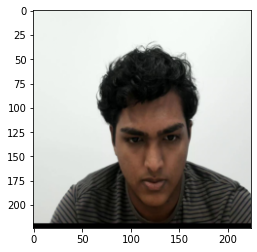

In [ ]:

plt.imshow(train_dataset[0][0].permute(1,2,0))

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  116.22999999999999


In [ ]:
train_loader = DataLoader( train_dataset, batch_size=5, shuffle=True )

valid_loader = DataLoader( valid_dataset, batch_size=5, shuffle=False )

dataloaders = {'train':train_loader, 'val':valid_loader}

### neural network

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from transformers import ViTForImageClassification, AdamW

ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=1)
                                                              # id2label=id2label,
                                                              # label2id=label2id)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'

In [ ]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=1):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=num_labels)
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        x,y = batch
        y = y.cuda().float()
        logits = self(x)
        criterion = nn.MSELoss()
        loss = criterion(logits, y)
        predictions = logits.argmax(-1)
        correct = (predictions == y).sum().item()
        accuracy = correct/x.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

In [ ]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=1
    )

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(max_epochs=10,gpus=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-pa

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.validate()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/lightning_logs/version_1/checkpoints/epoch=10-step=5500.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/lightning_logs/version_1/checkpoints/epoch=10-step=5500.ckpt


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy              0.0
     validation_loss        140.81130981445312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 140.81130981445312, 'validation_accuracy': 0.0}]

In [ ]:
test_img = Image.open('CroppedImages/12/frame102_cropped.jpg')
test_img = test_transforms(test_img)
test_img.to(device)


tensor([[[0.8824, 0.8824, 0.8824,  ..., 0.8824, 0.8824, 0.8824],
         [0.8824, 0.8824, 0.8824,  ..., 0.8824, 0.8824, 0.8824],
         [0.8824, 0.8824, 0.8824,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9020, 0.9020, 0.9020,  ..., 0.9020, 0.9020, 0.9020],
         [0.9020, 0.9020, 0.9020,  ..., 0.9020, 0.9020, 0.9020],
         [0.9020, 0.9020, 0.9020,  ..., 0.9020, 0.9020, 0.9020],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.8863],
         [0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.8863],
         [0.8863, 0.8863, 0.8863,  ..., 0.8863, 0.8863, 0.

In [ ]:
for i,(X,y) in enumerate(valid_loader):
  if i ==6:
    break
  X,y = X,y.float()
  output = model(X)
  print(output)
  print(y)

tensor([[80.0584],
        [80.0664],
        [80.0830],
        [80.0803],
        [80.0955]], grad_fn=<AddmmBackward0>)
tensor([ 73.1980,  69.5700,  99.8560, 100.6500,  78.7640])
tensor([[80.0706],
        [80.0586],
        [80.0850],
        [80.0800],
        [80.0692]], grad_fn=<AddmmBackward0>)
tensor([113.1560,  75.9300,  73.6000,  77.0200,  80.8360])
tensor([[80.0613],
        [80.0637],
        [80.0522],
        [80.0622],
        [80.0569]], grad_fn=<AddmmBackward0>)
tensor([85.5780, 82.5200, 75.1740, 72.0480, 76.2760])
tensor([[80.0879],
        [80.0713],
        [80.0801],
        [80.0659],
        [80.0336]], grad_fn=<AddmmBackward0>)
tensor([ 79.1060,  73.7020,  98.7900, 115.0060,  77.1240])
tensor([[80.0545],
        [80.0556],
        [80.0527],
        [80.0620],
        [80.0812]], grad_fn=<AddmmBackward0>)
tensor([85.2160, 82.3840, 70.1880, 76.4200, 84.6640])
tensor([[80.0550],
        [80.0761],
        [80.0607],
        [80.0569],
        [80.0547]], grad_fn=<

In [ ]:
model(X)

tensor([[80.0584],
        [80.0664],
        [80.0830],
        [80.0803],
        [80.0955]], grad_fn=<AddmmBackward0>)

In [ ]:
y

tensor([ 73.1980,  69.5700,  99.8560, 100.6500,  78.7640])

#### define the train function and loop

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='DEFAULT')
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights='DEFAULT')
# model = network_architectures.mobilenet_v1(pretrained= False)
# model = timm.create_model('xception', pretrained=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
## Mobilenetv1 and Mobilenetv2
# model.classifier[1] = nn.Linear(in_features=1280, out_features=5, bias=True)

## VGG model
model.classifier[6] = nn.Linear(4096,5)

## Xception model
#model.output = nn.Linear(2048,5)

In [ ]:
model,criterion,optimizer = network_f.setupModel(model)

#Define a Loss function and optimizer VGG
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001,momentum = 0.5)

params: 85802501


In [ ]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}
     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,labelBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device).float()
          labelBatch = labelBatch.to(device).float()
          
          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outputBatch = model(inputBatch)
          loss = criterion(outputBatch, labelBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      if check_every > 1:
        print(" | ", end='')
        for phase in phases:        
          print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  end_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, end_params

In [ ]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, epochs=5)

training model


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1066 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
model.load_state_dict(best_params)

<All keys matched successfully>

#### evaluate

In [ ]:
def evaluate(net, loader):

  net.eval()
  output_pred = []
  output_true = []
  actual_label = None
  pred_label = None

  for i, (inputBatch,labelBatch) in enumerate(tqdm(loader)):
      inputBatch = inputBatch.to(device).float()
      labelBatch = labelBatch.to(device)

      # forward
      with torch.no_grad():
        outputBatch = net(inputBatch)
      for output, label in zip(outputBatch,labelBatch):
        output_true.append(output.cpu().numpy())
        val, indx = torch.max(output,0)
        output_pred.append(val.cpu().numpy())


  print(classification_report(output_true,output_pred, digits=4))  

In [ ]:
evaluate(model, train_loader)

  0%|          | 0/1066 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
evaluate(model, valid_loader)